#Cài đặt thư viện và import dữ liệu

In [25]:
import warnings
warnings.filterwarnings('ignore')

time: 714 µs (started: 2023-12-21 06:24:50 +00:00)


In [26]:
!pip install nltk
!pip install underthesea
!pip install pyvi
!pip install langid
!pip install num2words
!pip install vietnam-number
!pip install tensorflow
!pip install --upgrade keras tensorflow
!pip install prettytable
!pip install imblearn
!pip install visualkeras
!pip install -q ipython-autotime
%load_ext autotime

  Using cached keras-3.0.1-py3-none-any.whl (999 kB)
  Using cached namex-0.0.7-py3-none-any.whl (5.8 kB)
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1min 29s (started: 2023-12-21 06:24:51 +00:00)


In [27]:
# mô hình tiếng Anh của spaCy
!python -m spacy download en_core_web_sm

2023-12-21 06:26:25.335474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 06:26:25.335564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 06:26:25.338133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 06:26:26.751571: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
time: 31.6 s (started: 2023-12-21 06:26:21 +00:00)


In [28]:
import pandas as pd
import numpy as np
import re
import regex
import string
import operator
import spacy
import joblib as jlb
from collections import Counter

time: 1 ms (started: 2023-12-21 06:26:52 +00:00)


In [29]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize as eng_sent

from underthesea import word_tokenize, pos_tag, sent_tokenize as vie_sent
from pyvi import ViPosTagger, ViTokenizer, ViUtils

import langid
from vietnam_number import n2w
import num2words

time: 70.7 ms (started: 2023-12-21 06:26:52 +00:00)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# trực quan
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from prettytable import PrettyTable

time: 1.01 ms (started: 2023-12-21 06:26:52 +00:00)


In [31]:
from nltk.classify import NaiveBayesClassifier
from nltk.classify import MaxentClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.utils.class_weight import compute_class_weight

import pickle as pkl
import tensorflow as tf

from keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

time: 5.89 ms (started: 2023-12-21 06:26:52 +00:00)


In [32]:
# https://drive.google.com/uc?id=1A8UreFunzXKY8z_ItXNl3kZMVlBla-kk
!gdown 1A8UreFunzXKY8z_ItXNl3kZMVlBla-kk

Downloading...
From: https://drive.google.com/uc?id=1A8UreFunzXKY8z_ItXNl3kZMVlBla-kk
To: /content/UEH-reviews-cleaned.xlsx
100% 77.8k/77.8k [00:00<00:00, 44.2MB/s]
time: 2.83 s (started: 2023-12-21 06:26:52 +00:00)


# Tiền xử lý và EDA

## EDA

In [33]:
file = r'UEH-reviews-cleaned.xlsx'
raw_df = pd.read_excel(file, sheet_name='Sheet1')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   reviewer   841 non-null    object 
 1   date       841 non-null    object 
 2   stars      831 non-null    float64
 3   likes      262 non-null    float64
 4   context    841 non-null    object 
 5   location   841 non-null    object 
 6   sentiment  841 non-null    object 
dtypes: float64(2), object(5)
memory usage: 46.1+ KB
time: 212 ms (started: 2023-12-21 06:26:55 +00:00)


In [34]:
raw_df.head(10)

,reviewer,date,stars,likes,context,location,sentiment
0,Thanh Nam Nguyễn,6 years ago,4.0,NaN,One of the best universities in Vietnam\n I m ...,uehA,positive
1,Vincent magnus Kenneth,2 years ago,5.0,NaN,"Trường sạch đẹp, giảng viên dễ thương,chương t...",uehA,positive
2,Binh Phuong Tang,a year ago,5.0,NaN,"Cơ sở vật chất hiện đại, thật tuyệt vời. 1 trư...",uehB,positive
3,Trà Lê Thị Thu,3 years ago,5.0,NaN,"Ngôi trường có đội ngũ giáo viên giỏi, nhiệt t...",uehA,positive
4,Long Trần,4 years ago,5.0,NaN,Hay tự ý đổi lịch học của học sinh :)\n nhưng ...,uehI,positive
5,hakun nguyen,7 years ago,5.0,NaN,"Truong rat dep. Có sân bóng chuyền, cầu lông, ...",uehQ8,positive
6,Văn Lê,a year ago,5.0,NaN,"Cơ sở vật chất hiện đại, không gian xanh và th...",uehN,positive
7,Huy Trần,9 years ago,4.0,NaN,"Được mỗi cái cơ sở này là đây đủ tiện nghi, và...",uehB,positive
8,Thiên Bùi,a year ago,5.0,NaN,"Trường rộng rãi, thoáng mát. Bãi đậu xe rộng r...",uehB,positive
9,Gia Nguyen,7 years ago,4.0,NaN,Nơi đào tạo các chuyên ngành kinh tế uy tính c...,uehB,positive


time: 16.2 ms (started: 2023-12-21 06:26:55 +00:00)


In [35]:
df = raw_df.copy()

time: 940 µs (started: 2023-12-21 06:26:55 +00:00)


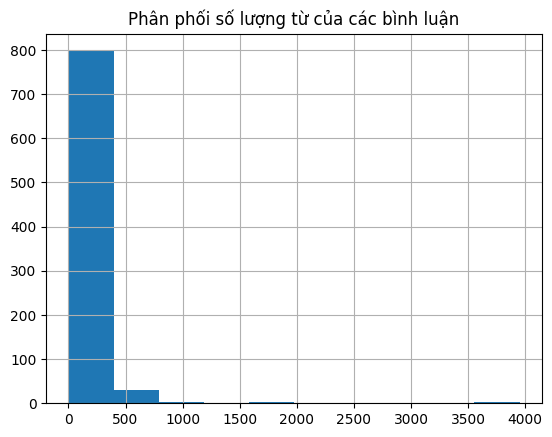

time: 289 ms (started: 2023-12-21 06:26:55 +00:00)


In [36]:
df['context'].str.len().hist()
plt.title('Phân phối số lượng từ của các bình luận')
plt.show()

In [37]:
# Lọc và hiển thị các dòng có số từ trên 500
over500_text_rows = df[df['context'].str.split().apply(len) > 500]
# Tổng số dòng có số từ lớn hơn 500
total_rows = len(over500_text_rows)
print(f"Tổng số dòng có số từ trên 500: {total_rows}")
# Hiển thị thông tin về các dòng đó
print("Các dòng có số từ trên 500:")
for index, row in over500_text_rows.iterrows():
    print(f"Index: {index}")

Tổng số dòng có số từ trên 500: 5
Các dòng có số từ trên 500:
Index: 673
Index: 697
Index: 698
Index: 711
Index: 726
time: 12.3 ms (started: 2023-12-21 06:26:56 +00:00)


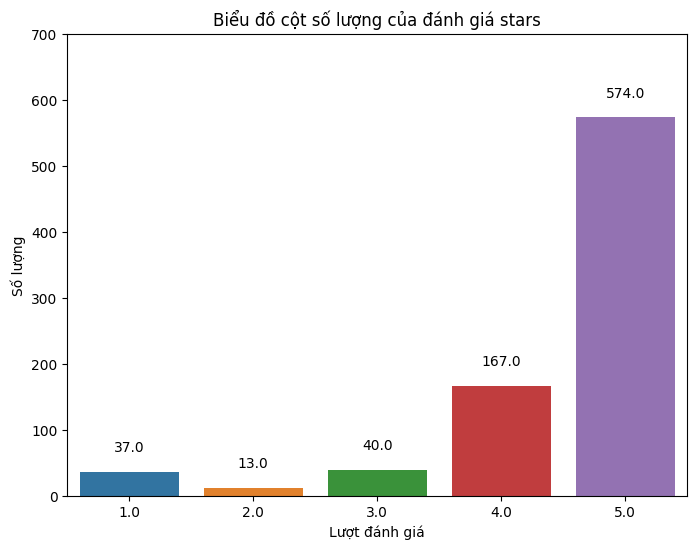

time: 282 ms (started: 2023-12-21 06:26:56 +00:00)


In [38]:
count_col_stars = df['stars'].value_counts().reset_index(name='count')
# Vẽ barplot với số lượng và khoảng cách giữa số và cột
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='index', y='count', data=count_col_stars)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.05 * ax.get_ylim()[1]),
                ha='center', va='baseline', fontsize=10, color='black')
plt.xlabel('Lượt đánh giá')
plt.ylabel('Số lượng')
plt.title('Biểu đồ cột số lượng của đánh giá stars')
plt.ylim(0, 700)
plt.show()

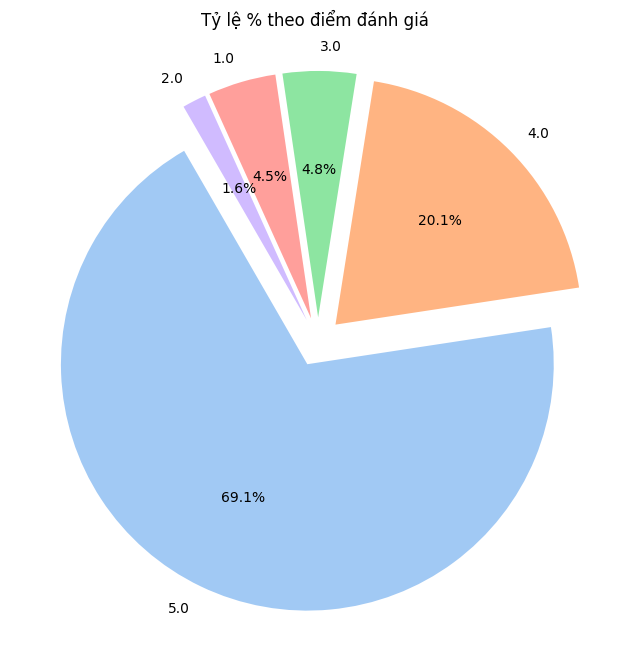

time: 226 ms (started: 2023-12-21 06:35:43 +00:00)


In [67]:
labels = count_col_stars['index']
sizes = count_col_stars['count']
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=120, explode=(0.1, 0.1, 0.1, 0.1, 0.1), colors=sns.color_palette('pastel'))
plt.title('Tỷ lệ % theo điểm đánh giá ')
plt.show()

## Tiền xử lý

In [45]:
def remove_punctuation(text):
    return ''.join([i for i in text if i not in string.punctuation])
def remove_emoji(text):
    emoji_pattern = re.compile('['
                              u'\U0001F600-\U0001F64F'  # emoticons
                              u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                              u'\U0001F680-\U0001F6FF'  # transport & map symbols
                              u'\U0001F700-\U0001F77F'  # alchemical symbols
                              u'\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
                              u'\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
                              u'\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
                              u'\U0001FA00-\U0001FA6F'  # Chess Symbols
                              u'\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
                              u'\U00002702-\U000027B0'  # Dingbats
                              u'\U000024C2-\U0001F251'
                              ']+', flags=re.UNICODE)
    return emoji_pattern.sub(r' ', text)
def preprocess(text):
    text = remove_punctuation(text)
    text = remove_emoji(text)
    text = text.lower()
    return text

time: 1.31 ms (started: 2023-12-21 06:30:16 +00:00)


In [46]:
df['pre_context'] = df['context'].apply(preprocess)
df.head(5)

,reviewer,date,stars,likes,context,location,sentiment,pre_context
0,Thanh Nam Nguyễn,6 years ago,4.0,NaN,One of the best universities in Vietnam\n I m ...,uehA,positive,one of the best universities in vietnam\n i m ...
1,Vincent magnus Kenneth,2 years ago,5.0,NaN,"Trường sạch đẹp, giảng viên dễ thương,chương t...",uehA,positive,trường sạch đẹp giảng viên dễ thươngchương trì...
2,Binh Phuong Tang,a year ago,5.0,NaN,"Cơ sở vật chất hiện đại, thật tuyệt vời. 1 trư...",uehB,positive,cơ sở vật chất hiện đại thật tuyệt vời 1 trườn...
3,Trà Lê Thị Thu,3 years ago,5.0,NaN,"Ngôi trường có đội ngũ giáo viên giỏi, nhiệt t...",uehA,positive,ngôi trường có đội ngũ giáo viên giỏi nhiệt tì...
4,Long Trần,4 years ago,5.0,NaN,Hay tự ý đổi lịch học của học sinh :)\n nhưng ...,uehI,positive,hay tự ý đổi lịch học của học sinh \n nhưng nh...


time: 68.3 ms (started: 2023-12-21 06:30:19 +00:00)


In [47]:
#Copy và sao lưu dữ liệu
df1 = df.copy()
df1.to_excel('df1.xlsx', index=False)

time: 197 ms (started: 2023-12-21 06:30:46 +00:00)


In [48]:
# Tạo cột để phân biệt 2 ngôn ngữ Anh-Việt
def detect_language(text):
    return langid.classify(text)[0]
df['language'] = df['pre_context'].apply(detect_language)

time: 3.94 s (started: 2023-12-21 06:30:48 +00:00)


In [49]:
# Tạo DF mới với từng ngôn ngữ
vn_df = df[df['language'] != 'en'].copy()
eng_df = df[df['language'] == 'en'].copy()

time: 10.8 ms (started: 2023-12-21 06:30:52 +00:00)


In [50]:
vn_df.head(5)

,reviewer,date,stars,likes,context,location,sentiment,pre_context,language
1,Vincent magnus Kenneth,2 years ago,5.0,NaN,"Trường sạch đẹp, giảng viên dễ thương,chương t...",uehA,positive,trường sạch đẹp giảng viên dễ thươngchương trì...,vi
2,Binh Phuong Tang,a year ago,5.0,NaN,"Cơ sở vật chất hiện đại, thật tuyệt vời. 1 trư...",uehB,positive,cơ sở vật chất hiện đại thật tuyệt vời 1 trườn...,vi
3,Trà Lê Thị Thu,3 years ago,5.0,NaN,"Ngôi trường có đội ngũ giáo viên giỏi, nhiệt t...",uehA,positive,ngôi trường có đội ngũ giáo viên giỏi nhiệt tì...,vi
4,Long Trần,4 years ago,5.0,NaN,Hay tự ý đổi lịch học của học sinh :)\n nhưng ...,uehI,positive,hay tự ý đổi lịch học của học sinh \n nhưng nh...,vi
5,hakun nguyen,7 years ago,5.0,NaN,"Truong rat dep. Có sân bóng chuyền, cầu lông, ...",uehQ8,positive,truong rat dep có sân bóng chuyền cầu lông bón...,vi


time: 12.9 ms (started: 2023-12-21 06:30:53 +00:00)


###Số và stopword dựa trên ngôn ngữ

In [51]:
def convert_n2w_eng(text):
    if text.isdigit():
        return num2words(text)
    else:
        return text
eng_df['pre_context'] = eng_df['pre_context'].apply(convert_n2w_eng)
eng_df.head(5)

,reviewer,date,stars,likes,context,location,sentiment,pre_context,language
0,Thanh Nam Nguyễn,6 years ago,4.0,NaN,One of the best universities in Vietnam\n I m ...,uehA,positive,one of the best universities in vietnam\n i m ...,en
11,Vtrippie Vietnam Free Tour Guides,7 years ago,4.0,NaN,Nice school with a good environment of club/gr...,uehA,positive,nice school with a good environment of clubgro...,en
16,Saori Nos,4 years ago,5.0,NaN,Vietnammese student is so cute and the food ne...,uehA,positive,vietnammese student is so cute and the food ne...,en
17,Ricky San Morgan,5 months ago,5.0,NaN,"Well maintained, clean and neat Campus, Great ...",uehA,positive,well maintained clean and neat campus great pl...,en
22,Đỗ Thị Hoàng Yến,2 years ago,5.0,NaN,This was a fantastic experience though the lib...,uehLibB,positive,this was a fantastic experience though the lib...,en


time: 19.5 ms (started: 2023-12-21 06:31:19 +00:00)


In [52]:
def convert_n2w_vn(text):
    if text.isdigit():
        return n2w(text)
    else:
        return text
vn_df['pre_context'] = vn_df['pre_context'].apply(convert_n2w_vn)
vn_df.head(5)

,reviewer,date,stars,likes,context,location,sentiment,pre_context,language
1,Vincent magnus Kenneth,2 years ago,5.0,NaN,"Trường sạch đẹp, giảng viên dễ thương,chương t...",uehA,positive,trường sạch đẹp giảng viên dễ thươngchương trì...,vi
2,Binh Phuong Tang,a year ago,5.0,NaN,"Cơ sở vật chất hiện đại, thật tuyệt vời. 1 trư...",uehB,positive,cơ sở vật chất hiện đại thật tuyệt vời 1 trườn...,vi
3,Trà Lê Thị Thu,3 years ago,5.0,NaN,"Ngôi trường có đội ngũ giáo viên giỏi, nhiệt t...",uehA,positive,ngôi trường có đội ngũ giáo viên giỏi nhiệt tì...,vi
4,Long Trần,4 years ago,5.0,NaN,Hay tự ý đổi lịch học của học sinh :)\n nhưng ...,uehI,positive,hay tự ý đổi lịch học của học sinh \n nhưng nh...,vi
5,hakun nguyen,7 years ago,5.0,NaN,"Truong rat dep. Có sân bóng chuyền, cầu lông, ...",uehQ8,positive,truong rat dep có sân bóng chuyền cầu lông bón...,vi


time: 15.1 ms (started: 2023-12-21 06:31:28 +00:00)


In [54]:
file_path = ('/content/vietnamese-stopwords.txt')
with open(file_path, 'r', encoding='utf-8') as file:
    vn_stopwords = file.readline()

time: 2.13 ms (started: 2023-12-21 06:31:42 +00:00)


In [55]:
# Xử lý stopwords cho tiếng Anh
eng_stopwords = nltk.corpus.stopwords.words('english')
eng_df['pre_context'] = eng_df['pre_context'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in eng_stopwords]))
# Xử lý stopwords cho tiếng Việt
vn_df['pre_context'] = vn_df['pre_context'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in vn_stopwords]))

time: 16.4 ms (started: 2023-12-21 06:31:44 +00:00)


In [56]:
eng_df.head()

,reviewer,date,stars,likes,context,location,sentiment,pre_context,language
0,Thanh Nam Nguyễn,6 years ago,4.0,NaN,One of the best universities in Vietnam\n I m ...,uehA,positive,one best universities vietnam great time place,en
11,Vtrippie Vietnam Free Tour Guides,7 years ago,4.0,NaN,Nice school with a good environment of club/gr...,uehA,positive,nice school good environment clubgroup activities,en
16,Saori Nos,4 years ago,5.0,NaN,Vietnammese student is so cute and the food ne...,uehA,positive,vietnammese student cute food nearby quite cheap,en
17,Ricky San Morgan,5 months ago,5.0,NaN,"Well maintained, clean and neat Campus, Great ...",uehA,positive,well maintained clean neat campus great place ...,en
22,Đỗ Thị Hoàng Yến,2 years ago,5.0,NaN,This was a fantastic experience though the lib...,uehLibB,positive,fantastic experience though library repair,en


time: 22.8 ms (started: 2023-12-21 06:31:47 +00:00)


In [57]:
vn_df.head()

,reviewer,date,stars,likes,context,location,sentiment,pre_context,language
1,Vincent magnus Kenneth,2 years ago,5.0,NaN,"Trường sạch đẹp, giảng viên dễ thương,chương t...",uehA,positive,trường sạch đẹp giảng viên dễ thươngchương trì...,vi
2,Binh Phuong Tang,a year ago,5.0,NaN,"Cơ sở vật chất hiện đại, thật tuyệt vời. 1 trư...",uehB,positive,cơ sở vật chất hiện đại thật tuyệt vời 1 trườn...,vi
3,Trà Lê Thị Thu,3 years ago,5.0,NaN,"Ngôi trường có đội ngũ giáo viên giỏi, nhiệt t...",uehA,positive,ngôi trường có đội ngũ giáo viên giỏi nhiệt tì...,vi
4,Long Trần,4 years ago,5.0,NaN,Hay tự ý đổi lịch học của học sinh :)\n nhưng ...,uehI,positive,hay tự ý đổi lịch học của học sinh nhưng nhìn ...,vi
5,hakun nguyen,7 years ago,5.0,NaN,"Truong rat dep. Có sân bóng chuyền, cầu lông, ...",uehQ8,positive,truong rat dep có sân bóng chuyền cầu lông bón...,vi


time: 20.8 ms (started: 2023-12-21 06:31:52 +00:00)


###Tokenize

In [58]:
df = pd.concat([vn_df, eng_df], axis=0, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reviewer     841 non-null    object 
 1   date         841 non-null    object 
 2   stars        831 non-null    float64
 3   likes        262 non-null    float64
 4   context      841 non-null    object 
 5   location     841 non-null    object 
 6   sentiment    841 non-null    object 
 7   pre_context  841 non-null    object 
 8   language     841 non-null    object 
dtypes: float64(2), object(7)
memory usage: 59.3+ KB
time: 15.3 ms (started: 2023-12-21 06:32:21 +00:00)


####Word Tokenize

In [59]:
special_char = [':',')','(','.',',',';','...']
for char in  special_char:
  df['pre_context'] = df['pre_context'].apply(lambda x: x.replace(char, ''))

df['pre_context'].head()

0    trường sạch đẹp giảng viên dễ thươngchương trì...
1    cơ sở vật chất hiện đại thật tuyệt vời 1 trườn...
2    ngôi trường có đội ngũ giáo viên giỏi nhiệt tì...
3    hay tự ý đổi lịch học của học sinh nhưng nhìn ...
4    truong rat dep có sân bóng chuyền cầu lông bón...
Name: pre_context, dtype: object

time: 10.8 ms (started: 2023-12-21 06:32:25 +00:00)


In [60]:
def wt(sentence, lang):
    if lang == 'en':
        tokens = word_tokenize(sentence)
    else:
        tokens = ViTokenizer.tokenize(sentence).split()
    return tokens

time: 770 µs (started: 2023-12-21 06:32:28 +00:00)


In [61]:
df['tokens'] = df.apply(lambda row: wt(row['pre_context'], row['language']), axis=1)
print(df['tokens'])

0      [trường, sạch, đẹp, giảng_viên, dễ, thươngchươ...
1      [cơ_sở, vật_chất, hiện_đại, thật, tuyệt_vời, 1...
2      [ngôi, trường, có, đội_ngũ, giáo_viên, giỏi, n...
3      [hay, tự_ý, đổi, lịch, học, của, học_sinh, như...
4      [truong, rat, dep, có, sân, bóng_chuyền, cầu_l...
                             ...                        
836    [best, school, town, economics, huge, placemen...
837    [excellent, university, world, class, educatio...
838    [new, campus, really, good, big, parking, spac...
839    [excellent, environment, good, campus, fully, ...
840    [one, best, universities, vietnam, great, time...
Name: tokens, Length: 841, dtype: object
time: 649 ms (started: 2023-12-21 06:32:31 +00:00)


In [62]:
english_tokens_list = [token for sublist in df[df['language'] == 'en']['tokens'].tolist() for token in sublist]
vietnamese_tokens_list = [token for sublist in df[df['language'] != 'en']['tokens'].tolist() for token in sublist]

# Display the lists of English and Vietnamese tokens
print("English Tokens:", english_tokens_list)
print("Vietnamese Tokens:", vietnamese_tokens_list)

English Tokens: ['one', 'best', 'universities', 'vietnam', 'great', 'time', 'place', 'nice', 'school', 'good', 'environment', 'clubgroup', 'activities', 'vietnammese', 'student', 'cute', 'food', 'nearby', 'quite', 'cheap', 'well', 'maintained', 'clean', 'neat', 'campus', 'great', 'place', 'education', 'fantastic', 'experience', 'though', 'library', 'repair', 'best', 'students', 'learners', 'interested', 'economics', 'largest', 'uni', 'south', 'vietnam', 'many', 'famous', 'lecturers', 'beautifull', 'school', 'food', 'served', 'school', 'amazing', 'infrastructure', 'high', 'quality', 'education', 'one', 'best', 'institution', 'vietnam', 'good', 'atmosphere', 'university', 'good', 'position', 'ho', 'chi minh', 'city', 'specially', 'economic', 'university', 'talent', 'students', 'new', 'capus', 'nice', 'building', 'morden', 'facilities', 'facilitiea', 'great', 'even', 'though', 'spacy', 'great', 'facility', 'good', 'location', 'students', 'best', 'place', 'education', 'good', 'environment'

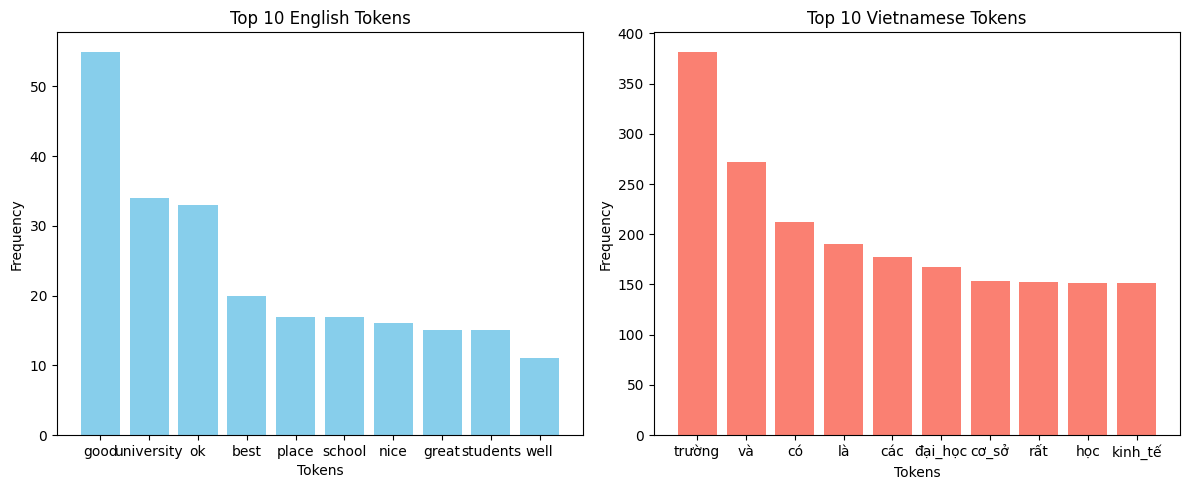

time: 957 ms (started: 2023-12-21 06:32:43 +00:00)


In [63]:
# Count the frequency of tokens in each list
english_token_counts = Counter(english_tokens_list)
vietnamese_token_counts = Counter(vietnamese_tokens_list)

# Get the top 10 most frequent tokens
top_10_english_tokens = dict(english_token_counts.most_common(10))
top_10_vietnamese_tokens = dict(vietnamese_token_counts.most_common(10))

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# English tokens plot
axes[0].bar(top_10_english_tokens.keys(), top_10_english_tokens.values(), color='skyblue')
axes[0].set_title('Top 10 English Tokens')
axes[0].set_xlabel('Tokens')
axes[0].set_ylabel('Frequency')

# Vietnamese tokens plot
axes[1].bar(top_10_vietnamese_tokens.keys(), top_10_vietnamese_tokens.values(), color='salmon')
axes[1].set_title('Top 10 Vietnamese Tokens')
axes[1].set_xlabel('Tokens')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


####Sentence Tokenize

In [68]:
sen_token = df.copy()

time: 2.41 ms (started: 2023-12-21 06:36:43 +00:00)


In [69]:
special_char_sen = [')','(',',','\n']
for char in  special_char_sen:
  sen_token['context'] = df['context'].apply(lambda x: x.replace(char, ''))

sen_token['context'].head()

0    Trường sạch đẹp, giảng viên dễ thương,chương t...
1    Cơ sở vật chất hiện đại, thật tuyệt vời. 1 trư...
2    Ngôi trường có đội ngũ giáo viên giỏi, nhiệt t...
3    Hay tự ý đổi lịch học của học sinh :) nhưng nh...
4    Truong rat dep. Có sân bóng chuyền, cầu lông, ...
Name: context, dtype: object

time: 14.7 ms (started: 2023-12-21 06:36:45 +00:00)


In [70]:
def st(sentence, lang):
    if lang == 'en':
        tokens = eng_sent(sentence)
    else:
        tokens = vie_sent(sentence)
    return tokens

time: 764 µs (started: 2023-12-21 06:36:47 +00:00)


In [71]:
sen_token['sent_tokens'] = sen_token.apply(lambda row: st(row['context'],
                                                          row['language']), axis=1)

sen_token['sent_tokens'].head()

0    [Trường sạch đẹp, giảng viên dễ thương,chương ...
1    [Cơ sở vật chất hiện đại, thật tuyệt vời., 1 t...
2    [Ngôi trường có đội ngũ giáo viên giỏi, nhiệt ...
3    [Hay tự ý đổi lịch học của học sinh :) nhưng n...
4    [Truong rat dep., Có sân bóng chuyền, cầu lông...
Name: sent_tokens, dtype: object

time: 120 ms (started: 2023-12-21 06:36:50 +00:00)


In [72]:
# Assuming 'tokens' column is already created in your DataFrame
english_sen_tokens_list = [token for sublist in sen_token[df['language'] == 'en']['sent_tokens'].tolist() for token in sublist]
vietnamese_sen_tokens_list = [token for sublist in sen_token[df['language'] != 'en']['sent_tokens'].tolist() for token in sublist]

# Display the lists of English and Vietnamese tokens
print("English Sentence Tokens:", english_sen_tokens_list)
print("Vietnamese Sentence Tokens:", vietnamese_sen_tokens_list)

English Sentence Tokens: ['One of the best universities in Vietnam I m having great time at this place', 'Nice school with a good environment of club/group and other activities', 'Vietnammese student is so cute and the food nearby are quite cheap ^^', 'Well maintained, clean and neat Campus, Great place for Education..!', 'This was a fantastic experience though the library is under repair', 'Best for the students or learners who are interested in economics', 'The Largest Uni.', 'Of South Vietnam with many famous lecturers.', 'So beautifull this school is!!', 'Food is not served at school.', 'Amazing infrastructure and very high quality in education', 'One of the best institution in Vietnam.', 'Good atmosphere', 'The University with good position in Ho Chi Minh City.', 'Specially Economic University for talent students.', 'New capus, nice building with morden facilities.', 'Facilitiea are great even though not too spacy', 'Great facility and good location for students.', 'Best place for

In [73]:
top5_longest_en = sorted(english_sen_tokens_list, key=len, reverse=True)[:5]
top5_longest_vi = sorted(vietnamese_sen_tokens_list, key=len, reverse=True)[:5]

# Display the results
print("Top 5 Longest English Sentence Tokens:")
for sentence in top5_longest_en:
  print(sentence, f'\nLenght: {len(sentence)} \n------------------------')

print("\nTop 5 Longest Vietnamese Sentence Tokens:")
for sentence in top5_longest_vi:
  print(sentence,  f'\nLenght: {len(sentence)} \n------------------------')

Top 5 Longest English Sentence Tokens:
I found that students did not adequately review material in the beginning of courses to build a solid foundation for later lectures - trust me they make more sense and you retain much more information (increasing your memory and understanding) just by listening to the lecturer having the background information.TL;DR: Work hard to get results. 
Lenght: 344 
------------------------
In first year in a science program, I would say I spent 2 nights per week socializing in first year, but otherwise was keeping up with all readings, reviewing lecture notes, doing recommended problems/readings, preparing for labs etc (including all weekends). 
Lenght: 259 
------------------------
Most of their office hours go unused for some reason, and then students complain about the difficulty of the material which to me only seems to be the case if they put in less effort than they thought was necessary, and got a less than stellar result. 
Lenght: 251 
------------

## POS_tagging

###Lọc và xử lý theo ngôn ngữ

Chuyển đổi cái tags của hai thư viện cho đồng bộ với nhau
- tham khảo POS của pyvi: [github.com](https://github.com/trungtv/pyvi/blob/master/README.rst)
- tham khảo POS của spacy: [melaniewalsh.github.io](https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/13-POS-Keywords.html)

In [74]:
# Số quan sát 2 ngôn ngữ
vie_df = df[df['language'] == 'vi']
eng_df = df[df['language'] == 'en']
print(f'Số quan sát tiếng Việt: {vie_df.shape[0]}')
print(f'Số quan sát tiếng Anh: {eng_df.shape[0]}')

Số quan sát tiếng Việt: 624
Số quan sát tiếng Anh: 181
time: 27.8 ms (started: 2023-12-21 06:37:25 +00:00)


In [75]:
pos = {
    'A': 'ADJ',  # Adjective: tính từ
    'C': 'CCONJ',  # Coordinating conjunction: liên từ
    'E': 'ADP',  # Preposition: giới từ
    'I': 'INTJ',  # Interjection: thán từ
    'L': 'DET',  # Determiner: đại từ xác định (a, an, the...)
    'M': 'NUM',  # Numeral: số
    'N': 'NOUN',  # Common noun: danh từ thông dụng
    'Nc': 'NOUN',  # Noun classifier: danh từ loại
    'Ny': 'NOUN',  # Noun abbreviation: danh từ viết tắt
    'Np': 'PROPN',  # Proper noun: tên riêng
    'Nu': 'NOUN',  # Unit noun: đơn vị
    'P': 'PRON',  # Pronoun: đại từ danh xưng
    'R': 'ADV',  # Adverb: trạng từ
    'S': 'SCONJ',  # Subordinating conjunction: liên từ phụ thuộc
    'T': 'AUX',  # Auxiliary, modal words: trợ động từ
    'V': 'VERB',  # Verb: động từ
    'F': 'PUNCT'  # Filtered out (punctuation): dấu cấu
}

time: 860 µs (started: 2023-12-21 06:37:25 +00:00)


In [76]:
full_viecontext = ' '.join(vie_df['pre_context'])
full_engcontext = ' '.join(eng_df['pre_context'])
print(f'Độ dài câu review tổng hợp tiếng Việt: {len(full_viecontext)}')
print(f'Độ dài câu review tổng hợp tiếng Anh: {len(full_engcontext)}')

Độ dài câu review tổng hợp tiếng Việt: 76159
Độ dài câu review tổng hợp tiếng Anh: 8350
time: 5.89 ms (started: 2023-12-21 06:37:26 +00:00)


In [77]:
# xử lý cho tiếng Việt
viecontext_postagger = ViPosTagger.postagging(ViTokenizer.tokenize(full_viecontext))
vieps_result = {word: pos.get(postag, 'X') for word, postag in zip(viecontext_postagger[0],
                            viecontext_postagger[1])} # X là other (những từ không xác định)
list(vieps_result.items())[:5]

[('trường', 'NOUN'),
 ('sạch', 'ADJ'),
 ('đẹp', 'ADJ'),
 ('giảng_viên', 'NOUN'),
 ('dễ', 'ADJ')]

time: 1.68 s (started: 2023-12-21 06:37:28 +00:00)


In [78]:
# xử lý cho tiếng Anh
engcontext_postagger = spacy.load('en_core_web_sm')(full_engcontext)
engps_result = {word.text: word.pos_ for word in engcontext_postagger}
list(engps_result.items())[:5]

[('one', 'NUM'),
 ('best', 'ADJ'),
 ('universities', 'NOUN'),
 ('vietnam', 'PROPN'),
 ('great', 'ADJ')]

time: 1.17 s (started: 2023-12-21 06:37:32 +00:00)


In [79]:
# combine kết quả và tạo df kết quả cả hai ngôn ngữ
pos_df = pd.DataFrame({
    'Word': list(vieps_result.keys()) + list(engps_result.keys()),
    'POS': list(vieps_result.values()) + list(engps_result.values()),
    'Ngôn ngữ': (['Tiếng Việt'] * len(vieps_result)) + (['Tiếng Anh'] * len(engps_result))
})
poscount_df = pos_df.groupby(['POS', 'Ngôn ngữ']).size().reset_index(name='Count')
poscount_df

,POS,Ngôn ngữ,Count
0,ADJ,Tiếng Anh,113
1,ADJ,Tiếng Việt,271
2,ADP,Tiếng Anh,5
3,ADP,Tiếng Việt,22
4,ADV,Tiếng Anh,42
5,ADV,Tiếng Việt,58
6,AUX,Tiếng Anh,10
7,AUX,Tiếng Việt,5
8,CCONJ,Tiếng Việt,15
9,DET,Tiếng Anh,1


time: 15.8 ms (started: 2023-12-21 06:37:36 +00:00)


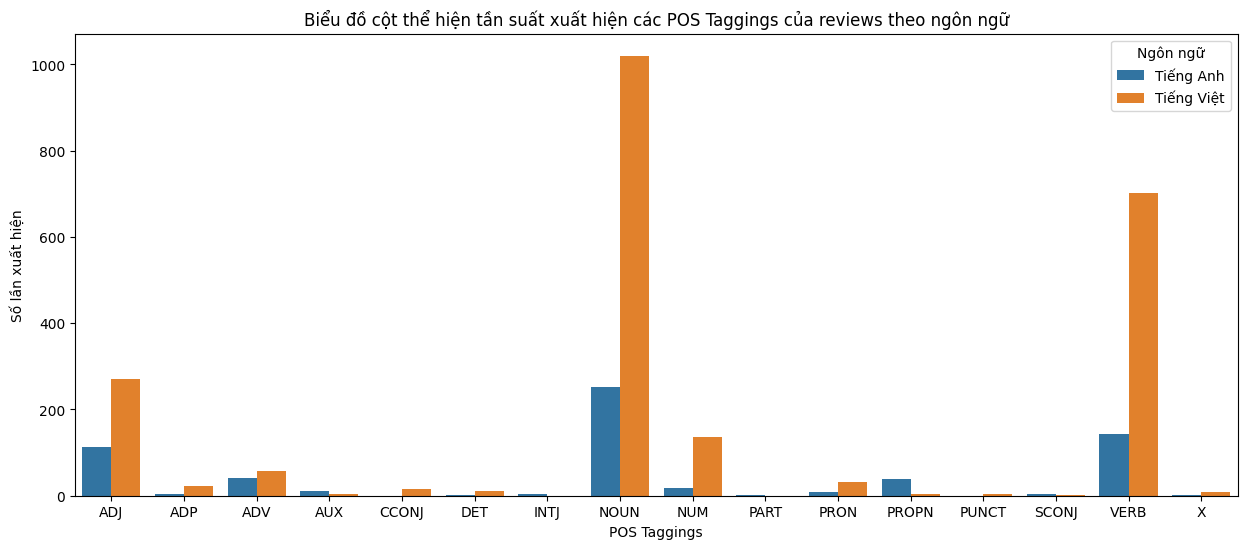

time: 445 ms (started: 2023-12-21 06:37:42 +00:00)


In [80]:
# trực quan
plt.figure(figsize=(15, 6))
sns.barplot(x=poscount_df['POS'], y=poscount_df['Count'], hue=poscount_df['Ngôn ngữ'])
plt.title('Biểu đồ cột thể hiện tần suất xuất hiện các POS Taggings của reviews theo ngôn ngữ')
plt.xlabel('POS Taggings')
plt.ylabel('Số lần xuất hiện')
plt.show()

###Xác định top chủ đề được đề cập nhiều nhất

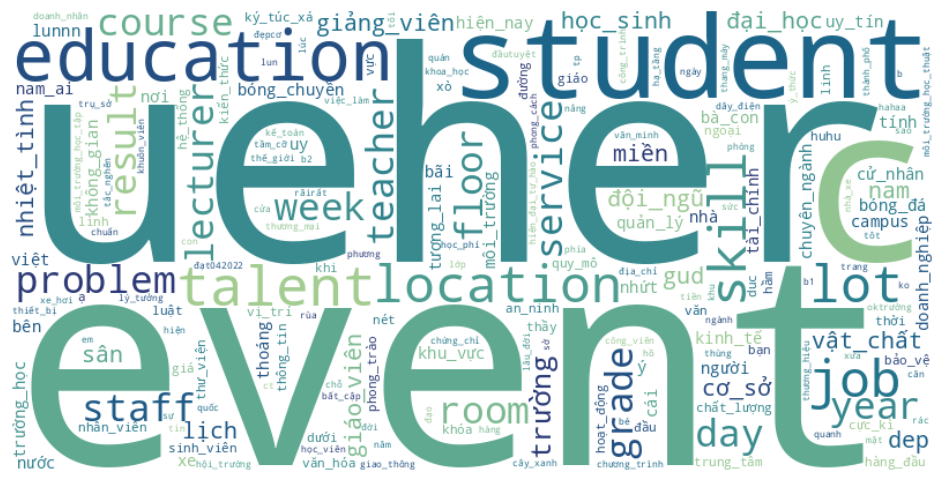

time: 1.2 s (started: 2023-12-21 06:39:21 +00:00)


In [87]:
# lọc token là danh từ và trực quan bằng wordcloud
result = {**vieps_result, **engps_result}
nouns_text = ' '.join([word for word, pos in result.items() if pos == 'NOUN'])
wordcloud = WordCloud(width=800, height=400, colormap=sns.color_palette("crest", as_cmap=True), background_color='white').generate_from_text(nouns_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [82]:
# tổng số lần xuất hiện
poscount_df.groupby('Ngôn ngữ')['Count'].sum()

Ngôn ngữ
Tiếng Anh      638
Tiếng Việt    2287
Name: Count, dtype: int64

time: 10.4 ms (started: 2023-12-21 06:38:19 +00:00)


In [83]:
# tìm các danh từ xuất hiện nhiều nhất
vienouns = {word: count for word, count in Counter(vieps_result.keys()).items() if vieps_result[word] == 'NOUN'}
vienouns = sorted(vienouns.items(), key=operator.itemgetter(1), reverse=True)
engnouns = {word: count for word, count in Counter(engps_result.keys()).items() if engps_result[word] == 'NOUN'}
engnouns = sorted(engnouns.items(), key=operator.itemgetter(1), reverse=True)
print(vienouns[:10])
print(engnouns[:10])

[('trường', 1), ('giảng_viên', 1), ('ueher', 1), ('cơ_sở', 1), ('vật_chất', 1), ('đại_học', 1), ('miền', 1), ('nam', 1), ('đội_ngũ', 1), ('giáo_viên', 1)]
[('universities', 1), ('time', 1), ('place', 1), ('school', 1), ('environment', 1), ('clubgroup', 1), ('activities', 1), ('vietnammese', 1), ('student', 1), ('food', 1)]
time: 9.18 ms (started: 2023-12-21 06:38:19 +00:00)


### Phân tích và đánh giá nội dung tiêu cực

#### Phân tích nội dung tiêu cực: Giảng viên

In [88]:
# tìm những review về chủ đề giảng viên cần cải thiện
lec_keywords = ['giảng viên', 'giáo viên', 'teacher', 'lecturer', 'khoa', 'đội ngũ', 'cán bộ', 'quản lý', 'văn phòng']
lec_negrvs = df[(df['sentiment'] == 'negative') & df['context'].str.contains('|'.join(lec_keywords), case=False)]
lec_negrvs = lec_negrvs.sort_values(by='likes', ascending=False)
lec_negrvs[['context', 'likes', 'location', 'sentiment', 'language']]

,context,likes,location,sentiment,language
575,Thái độ văn phòng đào tạo k tốt. Mình vào hỏi ...,20.0,uehA,negative,vi
570,"Tệ,mức học phí quá cao 930k/1 tín,tuyển sinh đ...",10.0,uehA,negative,vi
566,"Một ngôi trường lừa đảo, lúc tuyển sinh thì nó...",9.0,uehI,negative,vi
568,"Giảng viên không có tinh thần, phòng ban làm v...",9.0,uehA,negative,vi
550,Trường có cơ sở vật chất hiện đại không sử dụn...,7.0,uehB,negative,vi
557,NHƯỢC ĐIỂM:\n - Khi đi thực tập trường in cái ...,7.0,uehVL1,negative,vi
548,Cán bộ phòng ban hoàn toàn không có tin thần p...,6.0,uehA,negative,vi
530,"Giảng viên không có tinh thần, phòng ban làm v...",4.0,uehB,negative,vi
499,Mình đã xác minh là chỗ này đã đập bỏ rồi mà g...,3.0,uehB,negative,vi
490,"Cơ sở nhỏ xíu, cũ. Không có thư viện, không có...",2.0,uehE,negative,vi


time: 29.5 ms (started: 2023-12-21 06:41:12 +00:00)


In [89]:
# hiện chi tiết nội dung review
print(f'Số bình luận tiêu cực về chủ đề "Giảng viên" là {len(lec_negrvs)} reviews',
      '\n---------------------------------------------------------------------------')
for index, row in lec_negrvs.iterrows():
    print(f'Tên người đánh giá: {row["reviewer"]}\nCơ sở đánh giá: {row["location"]}\nNội dung đánh giá: {row["context"]}',
          '\n---------------------------------------------------------------------------')

Số bình luận tiêu cực về chủ đề "Giảng viên" là 15 reviews 
---------------------------------------------------------------------------
Tên người đánh giá: Gia Quốc
Cơ sở đánh giá: uehA
Nội dung đánh giá: Thái độ văn phòng đào tạo k tốt. Mình vào hỏi mà quát vào mặt. Chỉ nhớ bà cô đó tên quyên, mập. Đi nộp hồ sơ mà hỏi lòng vòng. Kiểu khinh khỉnh. Chưa biết bà đó có dạy học sinh k mà thái độ như bà nội thiên hạ. 
---------------------------------------------------------------------------
Tên người đánh giá: APB Phạm
Cơ sở đánh giá: uehA
Nội dung đánh giá: Tệ,mức học phí quá cao 930k/1 tín,tuyển sinh đầu vào không kĩ,xét học bạ nhiều,giảng viên dạy thiếu tâm huyết,thời gian học ít,cơ sở vật chất chưa đáp ứng được với lượng sinh viên, vậy mà trường còn tuyển khá nhiều chỉ tiêu, công tác đào tạo không chất lượng, càng thế hệ sau càng nát chỉ được danh tiếng của các thế hệ trước. 
---------------------------------------------------------------------------
Tên người đánh giá: Tân Nguyễn Hữu

#### Phân tích nội dung tiêu cực: Cơ sở vật chất

In [90]:
# tương tự như trên
fac_keywords = ['cơ sở vật chất', 'thiết bị', 'phòng học', 'thư viện', 'nhà xe', 'bãi xe', 'chỗ gửi xe', 'chỗ để xe',
                'phòng lab', 'không gian', 'AC', 'facilities', 'environment', 'facility', 'room', 'parking']
fac_negrvs = df[(df['sentiment'] == 'negative') & df['context'].str.contains('|'.join(fac_keywords), case=False)]
fac_negrvs = fac_negrvs.sort_values(by='likes', ascending=False)
print(f'Số bình luận tiêu cực về chủ đề "Cơ sở vật chất" là {len(fac_negrvs)} reviews',
      '\n---------------------------------------------------------------------------')
for index, row in fac_negrvs.iterrows():
    print(f'Tên người đánh giá: {row["reviewer"]}\nCơ sở đánh giá: {row["location"]}\nNội dung đánh giá: {row["context"]}',
          '\n---------------------------------------------------------------------------')

Số bình luận tiêu cực về chủ đề "Cơ sở vật chất" là 25 reviews 
---------------------------------------------------------------------------
Tên người đánh giá: APB Phạm
Cơ sở đánh giá: uehA
Nội dung đánh giá: Tệ,mức học phí quá cao 930k/1 tín,tuyển sinh đầu vào không kĩ,xét học bạ nhiều,giảng viên dạy thiếu tâm huyết,thời gian học ít,cơ sở vật chất chưa đáp ứng được với lượng sinh viên, vậy mà trường còn tuyển khá nhiều chỉ tiêu, công tác đào tạo không chất lượng, càng thế hệ sau càng nát chỉ được danh tiếng của các thế hệ trước. 
---------------------------------------------------------------------------
Tên người đánh giá: Bình Lê Thanh
Cơ sở đánh giá: uehB
Nội dung đánh giá: Trường có cơ sở vật chất hiện đại không sử dụng tối ưu
 Giảng viên giỏi và hay thì không còn dạy.
 Giảng viên cấp 3 thì nhiều, dạy thì chán, đọc sách giáo khoa ra không.
 Làm việc còn theo cơ chế xin cho, giải quyết quan liêu, giảng viên trưởng khoa nói năng thay trắng đổi đen, và giảng viên chơi đá bóng trách n

#### Phân tích nội dung tiêu cực: Hoạt động sinh viên

In [91]:
# tương tự như trên
activity_keywords = ['hoạt động', 'sinh viên', 'activity', 'activities', 'student', 'students', 'ueher', 'thái độ',
                     'club', 'câu lạc bộ', 'clb', 'đội', 'nhóm', 'sự kiện', 'ý thức', 'người học', 'học sinh']
activity_negrvs = df[(df['sentiment'] == 'negative') & df['context'].str.contains('|'.join(activity_keywords), case=False)]
activity_negrvs = activity_negrvs.sort_values(by='likes', ascending=False)
print(f'Số bình luận tiêu cực về chủ đề "Hoạt động sinh viên" là {len(fac_negrvs)} reviews',
      '\n---------------------------------------------------------------------------')
for index, row in activity_negrvs.iterrows():
    print(f'Tên người đánh giá: {row["reviewer"]}\nCơ sở đánh giá: {row["location"]}\nNội dung đánh giá: {row["context"]}\nLikes: {row["likes"]}\n---')

Số bình luận tiêu cực về chủ đề "Hoạt động sinh viên" là 25 reviews 
---------------------------------------------------------------------------
Tên người đánh giá: Gia Quốc
Cơ sở đánh giá: uehA
Nội dung đánh giá: Thái độ văn phòng đào tạo k tốt. Mình vào hỏi mà quát vào mặt. Chỉ nhớ bà cô đó tên quyên, mập. Đi nộp hồ sơ mà hỏi lòng vòng. Kiểu khinh khỉnh. Chưa biết bà đó có dạy học sinh k mà thái độ như bà nội thiên hạ.
Likes: 20.0
---
Tên người đánh giá: Khải Nguyễn
Cơ sở đánh giá: uehA
Nội dung đánh giá: Trường đại học kinh tế Tphcm một trong những trường đại học nổi tiếng nhất Việt Nam
 Khuôn viên khá yên tĩnh và sạch sẻ
 Chất lượng đào tào tốt
 Bãi giữ xe cũng nhỏ không quá rộng
 
 Tuy nhiên:
 Nằm ngay giữa trung tâm quận nhất nên vấn đề di chuyển có hơi khó khăn cho sinh viên giờ cao điểm
Likes: 11.0
---
Tên người đánh giá: APB Phạm
Cơ sở đánh giá: uehA
Nội dung đánh giá: Tệ,mức học phí quá cao 930k/1 tín,tuyển sinh đầu vào không kĩ,xét học bạ nhiều,giảng viên dạy thiếu tâm huyết

# Xây dựng mô hình

##Tiền xử lý

In [92]:
def create_data_tuples(df):
    data_tuples = []
    for index, row in df.iterrows():
        # Extract the list of words
        word_list = row['tokens']

        # Create a feature dictionary
        feature_dict = {word: True for word in word_list}

        data_tuples.append((feature_dict, row['sentiment']))
    return data_tuples

time: 956 µs (started: 2023-12-21 06:43:38 +00:00)


In [93]:
data_tuples = create_data_tuples(df)
print(data_tuples[0])

({'trường': True, 'sạch': True, 'đẹp': True, 'giảng_viên': True, 'dễ': True, 'thươngchương': True, 'trình': True, 'học': True, 'tốt': True, 'from': True, 'ueher': True, '43': True}, 'positive')
time: 51 ms (started: 2023-12-21 06:43:46 +00:00)


In [94]:
train_data, test_data = train_test_split(data_tuples, test_size=0.2, random_state=42)

time: 4.27 ms (started: 2023-12-21 06:43:47 +00:00)


In [95]:
def wt_predicted(sentence, lang):
    if lang == 'en':
        tokens = word_tokenize(sentence)
    else:
        tokens = ViTokenizer.tokenize(sentence).split()
    return dict([(token, True) for token in tokens])

time: 825 µs (started: 2023-12-21 06:43:47 +00:00)


In [96]:
def predict_sentiment(new_context, lang):
    features = wt_predicted(new_context, lang)
    predicted_label = classifier.classify(features)
    return predicted_label

time: 703 µs (started: 2023-12-21 06:43:47 +00:00)


##Naive Bayes

### Huấn luyện mô hình

In [97]:
# Train Naive Bayes Classifier
classifier = NaiveBayesClassifier.train(train_data)

time: 68 ms (started: 2023-12-21 06:43:47 +00:00)


In [98]:
predicted_labels = [classifier.classify(example[0]) for example in test_data]
true_labels = [example[1] for example in test_data]
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.8047337278106509
time: 14.8 ms (started: 2023-12-21 06:43:47 +00:00)


### Đánh giá mô hình

In [99]:
label_map = {label: i for i, label in enumerate(classifier.labels())}
true_labels_numeric = [label_map[label] for label in true_labels]
predicted_labels_numeric = [label_map[label] for label in predicted_labels]
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_numeric, predicted_labels_numeric, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9040990239215092
Recall: 0.8047337278106509
F1 Score: 0.8317195761243729
time: 8.91 ms (started: 2023-12-21 06:43:47 +00:00)


In [100]:
for example in test_data:
    context, true_label = example
    predicted_label = classifier.classify(context)
    print(f"Context: {context}, True Label: {true_label}, Predicted Label: {predicted_label}")

Context: {'gửi': True, 'xe': True, 'chật_chội': True, 'phòng': True, 'cũ': True, 'quá': True}, True Label: negative, Predicted Label: negative
Context: {'school': True}, True Label: positive, Predicted Label: positive
Context: {'trường': True, 'thì': True, 'khỏi': True, 'phải': True, 'chê': True, 'rùi': True, 'ạ': True, 'csvc': True, 'top': True, 'đầu': True, 'nha': True, 'yêu': True, 'ueh': True}, True Label: positive, Predicted Label: negative
Context: {'“': True, '…': True, 'là': True, 'bầu_trời': True, 'của': True, 'sự': True, 'trưởng_thành': True, 'bằng': True, 'cách': True, 'trải': True, 'nghiệm': True, 'việc_làm': True, 'thêm': True, '”': True, 'thật': True, 'nhiều': True, 'cảm_xúc': True, 'khó': True, 'tả': True, 'một': True, 'năm': True, 'trước': True, 'cũng': True, 'ngày': True, 'hôm_nay': True, 'mình': True, 'bắt_đầu': True, 'bước': True, 'vào': True, 'đây': True, 'làm': True, 'lúc': True, 'đó': True, 'chỉ': True, 'con': True, 'nhóc': True, 'vừa': True, 'thi': True, 'xong': 

### Áp dụng dự đoán

In [101]:
while True:
    text = input('> Hãy nhập câu bất kỳ: ')
    if text.lower() == 'end':
        break
    else:
        sentiment = predict_sentiment(text,'en')
        print(f'Kết quả dự đoán: {sentiment}\n')

> Hãy nhập câu bất kỳ: Sinh viên ngày càng đông nhưng cơ sở vật chất không đáp ứng được số lượng người học, bãi xe hay gặp tình trạng quá tải.
Kết quả dự đoán: negative

> Hãy nhập câu bất kỳ: Prestigious and old school in town. Parking lot is small and prioritized for teachers.
Kết quả dự đoán: negative

> Hãy nhập câu bất kỳ: end
time: 34 s (started: 2023-12-21 06:43:47 +00:00)


In [102]:
while True:
    text = input('> Hãy nhập câu bất kỳ: ')
    if text.lower() == 'end':
        break
    else:
        sentiment = predict_sentiment(text,'vn')
        print(f'Kết quả dự đoán: {sentiment}\n')

> Hãy nhập câu bất kỳ: Sinh viên ngày càng đông nhưng cơ sở vật chất không đáp ứng được số lượng người học, bãi xe hay gặp tình trạng quá tải.
Kết quả dự đoán: negative

> Hãy nhập câu bất kỳ: end
time: 28.7 s (started: 2023-12-21 06:44:21 +00:00)


##Maxent Classifier

### Huấn luyện mô hình

In [103]:
classifier = MaxentClassifier.train(train_data, trace=3, algorithm='iis', max_iter=20)

  ==> Training (20 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.866
             2          -0.34073        0.900
             3          -0.27419        0.943
             4          -0.24059        0.957
             5          -0.21844        0.967
             6          -0.20195        0.970
             7          -0.18884        0.976
             8          -0.17797        0.978
             9          -0.16871        0.982
            10          -0.16068        0.982
            11          -0.15362        0.982
            12          -0.14734        0.984
            13          -0.14170        0.987
            14          -0.13660        0.991
            15          -0.13195        0.993
            16          -0.12770        0.993
            17          -0.12379        0.993
            18          -0.12017        0.993
            19          -0.11681        0.993
  

In [104]:
#Sử dụng mô hình cho tập train
predicted_labels_train = [classifier.classify(example[0]) for example in train_data]
true_labels_train = [example[1] for example in train_data]

time: 37.7 ms (started: 2023-12-21 06:45:45 +00:00)


In [105]:
#Sử dụng mô hình cho tập test
predicted_labels_test = [classifier.classify(example[0]) for example in test_data]
true_labels_test = [example[1] for example in test_data]

time: 13.1 ms (started: 2023-12-21 06:45:45 +00:00)


### Đánh giá mô hình

In [106]:
#Tính các tham số đánh giá trên tập train
accuracy_train = accuracy_score(true_labels_train, predicted_labels_train)
precision_train = precision_score(true_labels_train, predicted_labels_train, average='weighted')
recall_train = recall_score(true_labels_train, predicted_labels_train, average='weighted')
f1_train = f1_score(true_labels_train, predicted_labels_train, average='weighted')
#Tính các tham số đánh giá trên tập test
accuracy_test = accuracy_score(true_labels_test, predicted_labels_test)
precision_test = precision_score(true_labels_test, predicted_labels_test, average='weighted')
recall_test = recall_score(true_labels_test, predicted_labels_test, average='weighted')
f1_test = f1_score(true_labels_test, predicted_labels_test, average='weighted')

time: 52.9 ms (started: 2023-12-21 06:45:45 +00:00)


In [107]:
def cal_neg_score (true_labels, predicted_labels, label ):
  cm = confusion_matrix(true_labels, predicted_labels, labels= label)
  tn, fp, fn, tp = cm.ravel()
  accuracy_negative = (tn + tp) / (tn + fp + fn + tp)
  precision_negative = tn / (tn + fn)
  recall_negative = tn / (tn + fp)
  f1_negative = 2 * (precision_negative * recall_negative) / (precision_negative + recall_negative)
  return accuracy_negative, precision_negative, recall_negative, f1_negative

time: 1.05 ms (started: 2023-12-21 06:45:45 +00:00)


In [108]:
an_test , pn_test, rn_test, fn_test =  cal_neg_score(true_labels_test, predicted_labels_test, ['negative', 'positive'])
an_train , pn_train, rn_train, fn_train =  cal_neg_score(true_labels_train, predicted_labels_train, ['negative', 'positive'])

time: 13.6 ms (started: 2023-12-21 06:45:45 +00:00)


In [109]:
myTable = PrettyTable(['Metrics','P_Train' , 'P_Test', 'N_train', 'N_test'])
myTable.add_row(['Accuracy', accuracy_train, accuracy_test, an_train, an_test])
myTable.add_row(['Precision', precision_train, precision_test, pn_train, pn_test])
myTable.add_row(['recall', recall_train, recall_test, rn_train, rn_test])
myTable.add_row(['f1', f1_train, f1_test, fn_train, fn_test])
print('Bảng đánh giá')
print(myTable)

Bảng đánh giá
+-----------+--------------------+--------------------+--------------------+--------------------+
|  Metrics  |      P_Train       |       P_Test       |      N_train       |       N_test       |
+-----------+--------------------+--------------------+--------------------+--------------------+
|  Accuracy | 0.9925595238095238 | 0.8875739644970414 | 0.9925595238095238 | 0.8875739644970414 |
| Precision | 0.9926034593633561 | 0.873364600659886  | 0.967032967032967  | 0.6428571428571429 |
|   recall  | 0.9925595238095238 | 0.8875739644970414 | 0.9777777777777777 | 0.391304347826087  |
|     f1    | 0.9925768787821823 | 0.875581315652872  | 0.9723756906077348 | 0.4864864864864865 |
+-----------+--------------------+--------------------+--------------------+--------------------+
time: 5.07 ms (started: 2023-12-21 06:45:45 +00:00)


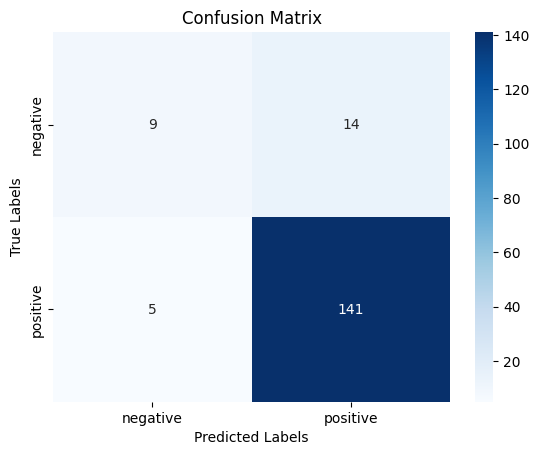

time: 257 ms (started: 2023-12-21 06:45:45 +00:00)


In [110]:
le = LabelEncoder()
true_labels_encoded = le.fit_transform(true_labels_test)
predicted_labels_encoded = le.transform(predicted_labels_test)

cm = confusion_matrix(true_labels_encoded, predicted_labels_encoded)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Áp dụng dự đoán

In [111]:
new_context = "Giảng viên tệ, không hết mình"
predicted_sentiment = predict_sentiment(new_context, 'vn')
print(f"Predicted Sentiment for '{new_context}': {predicted_sentiment}")
new_context1 = "Sinh viên ồn ào, bãi xe chật chội"
predicted_sentiment1 = predict_sentiment(new_context1, 'vn')
print(f"Predicted Sentiment for '{new_context1}': {predicted_sentiment1}")
new_context2 = "One of the best university in VietNam"
predicted_sentiment2 = predict_sentiment(new_context2, 'en')
print(f"Predicted Sentiment for '{new_context2}': {predicted_sentiment2}")
new_context3 = "Trường học khang trang mát mẻ, chất lượng đào tạo tốt"
predicted_sentiment3 = predict_sentiment(new_context3, 'vn')
print(f"Predicted Sentiment for '{new_context3}': {predicted_sentiment3}")
new_context4 = "Chất lượng giảng đường không tốt, không khí ngột ngạt"
predicted_sentiment4 = predict_sentiment(new_context4, 'vn')
print(f"Predicted Sentiment for '{new_context4}': {predicted_sentiment4}")

Predicted Sentiment for 'Giảng viên tệ, không hết mình': negative
Predicted Sentiment for 'Sinh viên ồn ào, bãi xe chật chội': negative
Predicted Sentiment for 'One of the best university in VietNam': positive
Predicted Sentiment for 'Trường học khang trang mát mẻ, chất lượng đào tạo tốt': positive
Predicted Sentiment for 'Chất lượng giảng đường không tốt, không khí ngột ngạt': positive
time: 7.88 ms (started: 2023-12-21 06:45:45 +00:00)


##CNN & BiLSTM

###Huấn luyện mô hình

In [112]:
df = pd.DataFrame({'nội dung': df['pre_context'], 'nhãn': df['sentiment']})
df = df.dropna().reset_index(drop=True)
df

,nội dung,nhãn
0,trường sạch đẹp giảng viên dễ thươngchương trì...,positive
1,cơ sở vật chất hiện đại thật tuyệt vời 1 trườn...,positive
2,ngôi trường có đội ngũ giáo viên giỏi nhiệt tì...,positive
3,hay tự ý đổi lịch học của học sinh nhưng nhìn ...,positive
4,truong rat dep có sân bóng chuyền cầu lông bón...,positive
...,...,...
836,best school town economics huge placement oppo...,positive
837,excellent university world class education bes...,positive
838,new campus really good big parking space prett...,positive
839,excellent environment good campus fully equipp...,positive


time: 16.3 ms (started: 2023-12-21 06:45:45 +00:00)


In [113]:
df.nunique()

nội dung    714
nhãn          2
dtype: int64

time: 10.7 ms (started: 2023-12-21 06:45:45 +00:00)


In [114]:
# nhân bản câu tiếng Việt để train cả có dấu và không dấu
input_pre = []
label_pre = []
text = df['nội dung'].values
label = df['nhãn'].values
for i, data in enumerate(text):
    input_text = list(tf.keras.preprocessing.text.text_to_word_sequence(data))
    input_text = ' '.join(input_text)
    if any(char > 127 for char in map(ord, data)):
        input_text_accent = ViTokenizer.tokenize(input_text)
        input_text_no_accent = str(ViUtils.remove_accents(input_text).decode('utf-8'))
        input_pre.extend([input_text_accent, input_text_no_accent])
        label_pre.extend([label[i], label[i]])
    else:
        input_pre.append(input_text)
        label_pre.append(label[i])
print(len(input_pre))
input_pre

1475


['trường sạch đẹp giảng_viên dễ thươngchương trình học tốt from ueher 43',
 'truong sach dep giang vien de thuongchuong trinh hoc tot from ueher 43',
 'cơ_sở vật_chất hiện_đại thật tuyệt_vời 1 trường đại_học lớn của miền nam',
 'co so vat chat hien dai that tuyet voi 1 truong dai hoc lon cua mien nam',
 'ngôi trường có đội_ngũ giáo_viên giỏi nhiệt_tình và vô_cùng dễ_thương …',
 'ngoi truong co doi ngu giao vien gioi nhiet tinh va vo cung de thuong ...',
 'hay tự_ý đổi lịch học của học_sinh nhưng nhìn_chung rất là tốt gud gud',
 'hay tu y doi lich hoc cua hoc sinh nhung nhin chung rat la tot gud gud',
 'truong rat dep có sân bóng_chuyền cầu_lông bóng_đá nữa mình rất yêu ý',
 'truong rat dep co san bong chuyen cau long bong da nua minh rat yeu y',
 'cơ_sở vật_chất hiện_đại không_gian xanh và thoáng mọi người thân_thiện',
 'co so vat chat hien dai khong gian xanh va thoang moi nguoi than thien',
 'được mỗi cái cơ_sở này là đây đủ tiện_nghi và giống cái trường_học nhất',
 'duoc moi cai co 

time: 387 ms (started: 2023-12-21 06:45:45 +00:00)


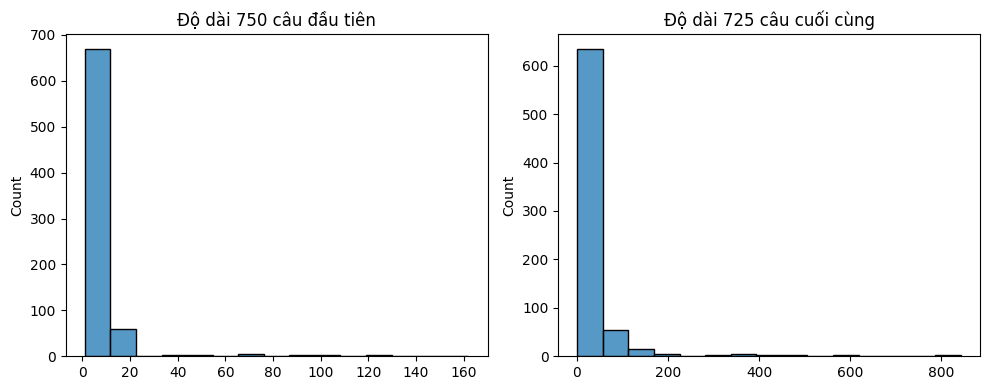

time: 620 ms (started: 2023-12-21 06:45:46 +00:00)


In [115]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
lim = 750

seq_len_1 = [len(i.split()) for i in input_pre[:lim]]
sns.histplot(seq_len_1, bins=15, kde=False, ax=axes[0])
axes[0].set_title(f'Độ dài {lim} câu đầu tiên')

seq_len_2 = [len(i.split()) for i in input_pre[lim:]]
sns.histplot(seq_len_2, bins=15, kde=False, ax=axes[1])
axes[1].set_title(f'Độ dài {len(input_pre)-lim} câu cuối cùng')

plt.tight_layout()
plt.show()

In [116]:
label_dict = {'negative': 0, 'positive': 1}
label_idx = [label_dict[i] for i in label_pre]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=2, dtype='float32')

maxlen_vector = 600
tokenizer_data = Tokenizer(oov_token='<OOV>', filters='', split=' ')
tokenizer_data.fit_on_texts(input_pre)
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=maxlen_vector)

pkl.dump(tokenizer_data, open('tokenizer_data.pkl', 'wb'))

print(f'Dữ liệu đầu vào (số quan sát, số chiều vector): {vec_data.shape}')
data_vocab_size = len(tokenizer_data.word_index)+1
print(f'Vocab size: {data_vocab_size}')

X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f'Số quan sát tập train: {len(X_train)}')
print(f'Số quan sát tập validation: {len(X_val)}')
print(f'Số quan sát tập test: {len(X_test)}')

Dữ liệu đầu vào (số quan sát, số chiều vector): (1475, 600)
Vocab size: 3532
Số quan sát tập train: 944
Số quan sát tập validation: 295
Số quan sát tập test: 236
time: 96.3 ms (started: 2023-12-21 06:45:47 +00:00)


In [117]:
def model():
    dropout_threshold = 0.2
    initializer = tf.keras.initializers.GlorotNormal()
    input_layer = Input(shape=(maxlen_vector,))

    # tạo Embedding để làm input layer
    feature = Embedding(input_dim=data_vocab_size, output_dim=32, input_length=maxlen_vector,
                        embeddings_initializer='GlorotNormal')(input_layer)

    # CNN
    cnn_feature = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # BiLSTM
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True,
                                         kernel_initializer=initializer))(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True,
                                        kernel_initializer=initializer))(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # kết hợp hai model
    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    # các dense layers
    classifier = Dense(70, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(2, activation='softmax')(classifier)

    # xây dựng mô hình cuối cùng
    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

time: 1.61 ms (started: 2023-12-21 06:45:47 +00:00)


In [118]:
model = model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 600)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 600, 32)              113024    ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 600, 32)              2080      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 300, 32)              0         ['conv1d[0][0]']              
 D)                                                                                           

In [119]:
# fit model
callback_model = tf.keras.callbacks.ModelCheckpoint('CNN-BILSTM_model.h5',
                                                    monitor='val_loss')
history = model.fit(x=X_train, y=y_train, epochs=20, batch_size=128,
                    validation_split=0.1, callbacks=[callback_model])

Epoch 1/20
7/7 [==============================] - 32s 3s/step - loss: 0.4569 - accuracy: 0.8457 - val_loss: 0.4383 - val_accuracy: 0.8421
Epoch 2/20
7/7 [==============================] - 17s 2s/step - loss: 0.4179 - accuracy: 0.8528 - val_loss: 0.4349 - val_accuracy: 0.8421
Epoch 3/20
7/7 [==============================] - 14s 2s/step - loss: 0.4255 - accuracy: 0.8528 - val_loss: 0.4262 - val_accuracy: 0.8421
Epoch 4/20
7/7 [==============================] - 15s 2s/step - loss: 0.3979 - accuracy: 0.8528 - val_loss: 0.4146 - val_accuracy: 0.8421
Epoch 5/20
7/7 [==============================] - 15s 2s/step - loss: 0.3732 - accuracy: 0.8528 - val_loss: 0.4057 - val_accuracy: 0.8421
Epoch 6/20
7/7 [==============================] - 19s 3s/step - loss: 0.3554 - accuracy: 0.8528 - val_loss: 0.3837 - val_accuracy: 0.8421
Epoch 7/20
7/7 [==============================] - 22s 3s/step - loss: 0.2893 - accuracy: 0.8528 - val_loss: 0.3402 - val_accuracy: 0.8421
Epoch 8/20
7/7 [==================

In [120]:
model.load_weights('CNN-BILSTM_model.h5')
model.evaluate(X_test, y_test)

8/8 [==============================] - 2s 211ms/step - loss: 0.6477 - accuracy: 0.8983


[0.6477447748184204, 0.8983050584793091]

time: 2.68 s (started: 2023-12-21 06:50:18 +00:00)


In [121]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print(classification_report(y_true_labels, y_pred_labels))

8/8 [==============================] - 8s 286ms/step
              precision    recall  f1-score   support

           0       0.62      0.66      0.64        32
           1       0.95      0.94      0.94       204

    accuracy                           0.90       236
   macro avg       0.78      0.80      0.79       236
weighted avg       0.90      0.90      0.90       236

time: 10.3 s (started: 2023-12-21 06:50:20 +00:00)


In [138]:
# fit model nhma do data bị imbalance nên gán thêm trọng số weight
callback_model = tf.keras.callbacks.ModelCheckpoint('CNN-BILSTM_model.h5',
                                                    monitor='val_loss')
weights = {}
class_weights = compute_class_weight('balanced',
                classes=np.unique(label_pre), y=label_pre)
for index, weight in enumerate(class_weights) :
  weights[index] = weight

history = model.fit(x=X_train, y=y_train, class_weight=weights, epochs=20,
          batch_size=128, validation_split=0.1, callbacks=[callback_model])

Epoch 1/20
7/7 [==============================] - 16s 2s/step - loss: 0.0054 - accuracy: 0.9976 - val_loss: 0.4710 - val_accuracy: 0.9158
Epoch 2/20
7/7 [==============================] - 13s 2s/step - loss: 0.0097 - accuracy: 0.9976 - val_loss: 0.4810 - val_accuracy: 0.9158
Epoch 3/20
7/7 [==============================] - 10s 2s/step - loss: 0.0050 - accuracy: 0.9976 - val_loss: 0.4830 - val_accuracy: 0.9053
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.0051 - accuracy: 0.9976 - val_loss: 0.4854 - val_accuracy: 0.9263
Epoch 5/20
7/7 [==============================] - 11s 2s/step - loss: 0.0043 - accuracy: 0.9976 - val_loss: 0.4924 - val_accuracy: 0.9263
Epoch 6/20
7/7 [==============================] - 10s 2s/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.5028 - val_accuracy: 0.9263
Epoch 7/20
7/7 [==============================] - 10s 1s/step - loss: 0.0099 - accuracy: 0.9976 - val_loss: 0.5076 - val_accuracy: 0.9263
Epoch 8/20
7/7 [===================

In [139]:
model.load_weights('CNN-BILSTM_model.h5')
model.evaluate(X_test, y_test)

8/8 [==============================] - 1s 131ms/step - loss: 0.9834 - accuracy: 0.9025


[0.9833813905715942, 0.9025423526763916]

time: 1.2 s (started: 2023-12-21 07:13:47 +00:00)


In [140]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print(classification_report(y_true_labels, y_pred_labels))

8/8 [==============================] - 1s 133ms/step
              precision    recall  f1-score   support

           0       0.63      0.69      0.66        32
           1       0.95      0.94      0.94       204

    accuracy                           0.90       236
   macro avg       0.79      0.81      0.80       236
weighted avg       0.91      0.90      0.90       236

time: 1.38 s (started: 2023-12-21 07:13:48 +00:00)


### Áp dụng dự đoán

In [141]:
def get_vectorize(input, tokenizer):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(input))
    input_text_pre = ' '.join(input_text_pre)
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    print(f'Input đã được xử lý là: {input_text_pre_accent}')
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=600)
    return vec_data

def get_confidence(feature, model):
    label_dict = {'negative': 0, 'positive': 1}
    label = list(label_dict.keys())
    output = model(feature).numpy()[0]
    result = output.argmax()
    conf = float(output.max())
    return label[int(result)], conf

def get_prediction(input, tokenizer, model):
    input_model = get_vectorize(input, tokenizer)
    result, conf = get_confidence(input_model, model)
    return result, conf

model_using = load_model('CNN-BILSTM_model.h5', compile=False)
with open('tokenizer_data.pkl', 'rb') as file:
    tokenizer_using = pkl.load(file)

time: 1.53 s (started: 2023-12-21 07:14:42 +00:00)


In [142]:
print(get_prediction('mấy chú bãi giữ xe hay đuổi sinh viên', tokenizer_using, model_using))
print(get_prediction('sinh viên nhiệt tình, hay giúp đỡ bạn bè', tokenizer_using, model_using))

Input đã được xử lý là: mấy chú bãi giữ xe hay đuổi sinh_viên
('negative', 1.0)
Input đã được xử lý là: sinh_viên nhiệt_tình hay giúp_đỡ bạn_bè
('positive', 1.0)
time: 4.58 s (started: 2023-12-21 07:14:44 +00:00)


In [143]:
while(True):
    text = input('> Hãy nhập câu bất kỳ: ')
    print(get_prediction(text, tokenizer_using, model_using)[0]+'\n---')
    if (input('Tiếp tục (C/K)? ').upper() == 'K'):
        break
print('---\nKết thúc.')


> Hãy nhập câu bất kỳ: Sinh viên ồn ào, bãi xe chật chội
Input đã được xử lý là: sinh_viên ồn_ào bãi xe chật_chội
negative
---
Tiếp tục (C/K)? c
> Hãy nhập câu bất kỳ: One of the best university in VietNam
Input đã được xử lý là: one of the best university in vietnam
positive
---
Tiếp tục (C/K)? c
> Hãy nhập câu bất kỳ: Trường học khang trang mát mẻ, chất lượng đào tạo tốt
Input đã được xử lý là: trường_học khang_trang mát_mẻ chất_lượng đào_tạo tốt
positive
---
Tiếp tục (C/K)? k
---
Kết thúc.
time: 25 s (started: 2023-12-21 07:14:56 +00:00)


###Trực quan kiến trúc mô hình
Tham khảo: [visualkeras](www.analyticsvidhya.com/blog/2022/03/visualize-deep-learning-models-using-visualkeras/)

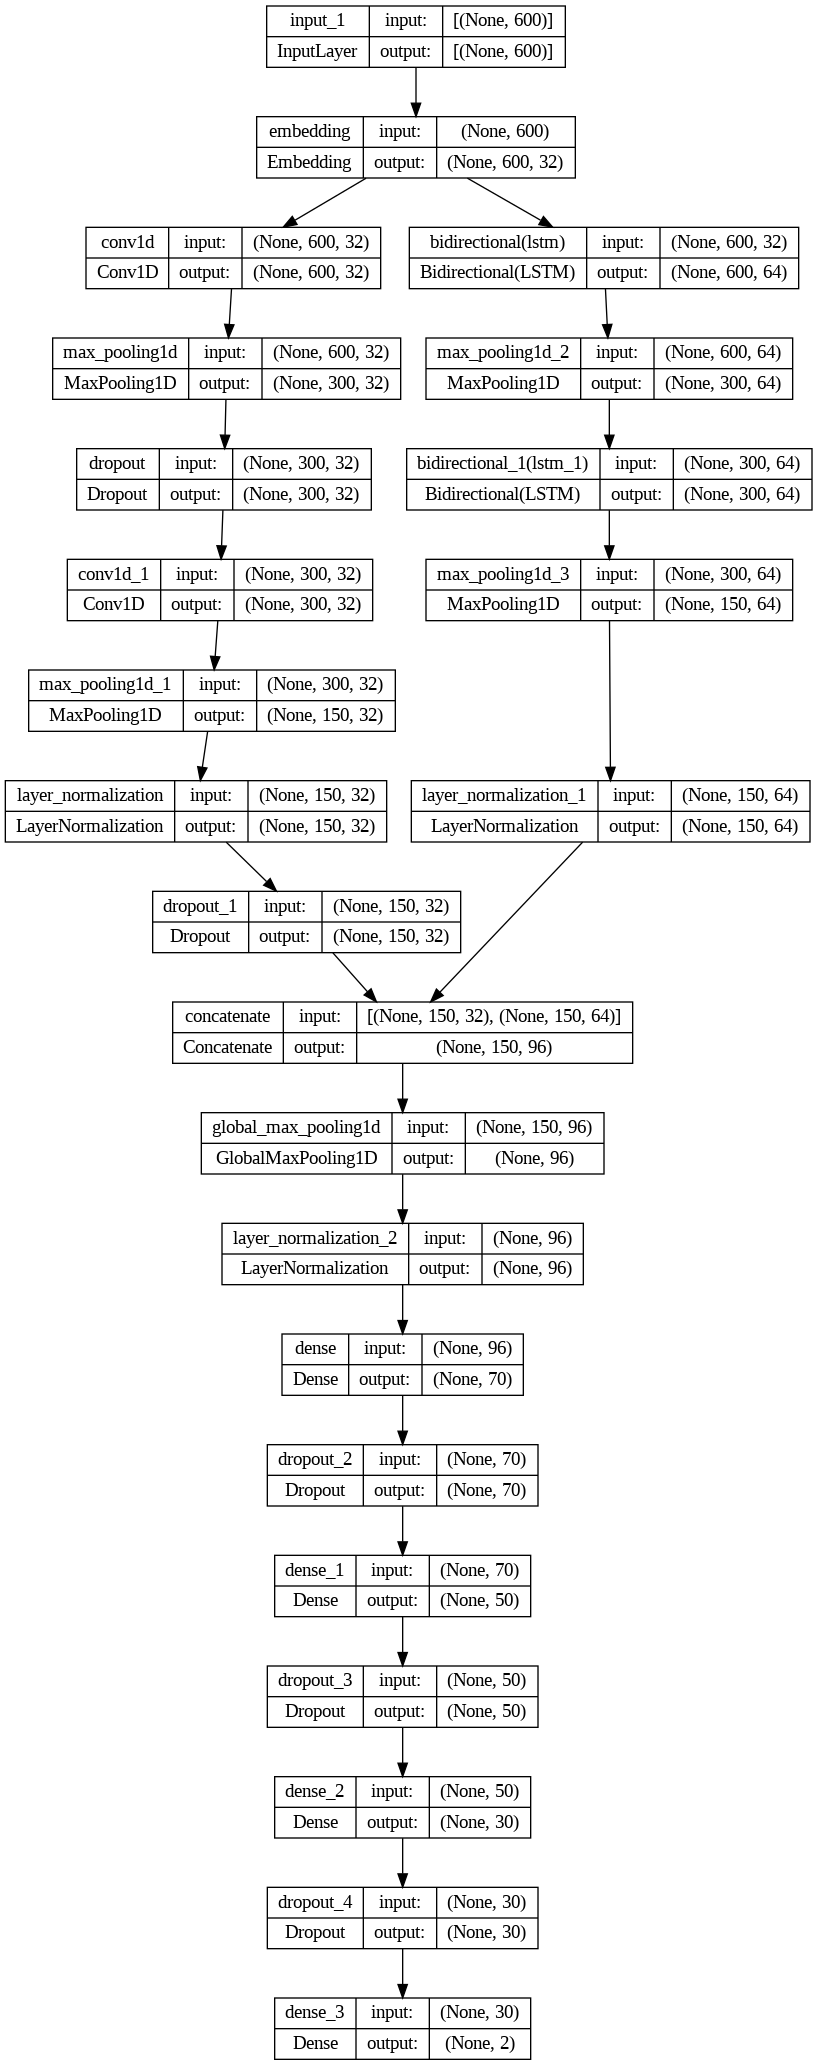

time: 484 ms (started: 2023-12-21 06:55:29 +00:00)


In [128]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# So sánh 3 mô hình

In [145]:
# kết quả metrics của 3 mô hình từ các file notebook trước
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
nbc_metrics = [0.8047, 0.9041, 0.8047, 0.8317]
mc_metrics = [0.8876, 0.8734, 0.8876, 0.8756]
cb_metrics = [0.90, 0.95, 0.94, 0.94]
cbw_metrics = [0.90, 0.95, 0.94, 0.94]

data = pd.DataFrame({
    'Model': ['NaiveBayesClassifier']*4 + ['MaxentClassifier']*4 + ['CNN & BiLSTM']*4 + ['CNN & BiLSTM (weighted)']*4,
    'Metric': labels*4,
    'Score': nbc_metrics + mc_metrics + cb_metrics + cbw_metrics
})
data

,Model,Metric,Score
0,NaiveBayesClassifier,Accuracy,0.8047
1,NaiveBayesClassifier,Precision,0.9041
2,NaiveBayesClassifier,Recall,0.8047
3,NaiveBayesClassifier,F1-score,0.8317
4,MaxentClassifier,Accuracy,0.8876
5,MaxentClassifier,Precision,0.8734
6,MaxentClassifier,Recall,0.8876
7,MaxentClassifier,F1-score,0.8756
8,CNN & BiLSTM,Accuracy,0.9000
9,CNN & BiLSTM,Precision,0.9500


time: 66.3 ms (started: 2023-12-21 07:16:25 +00:00)


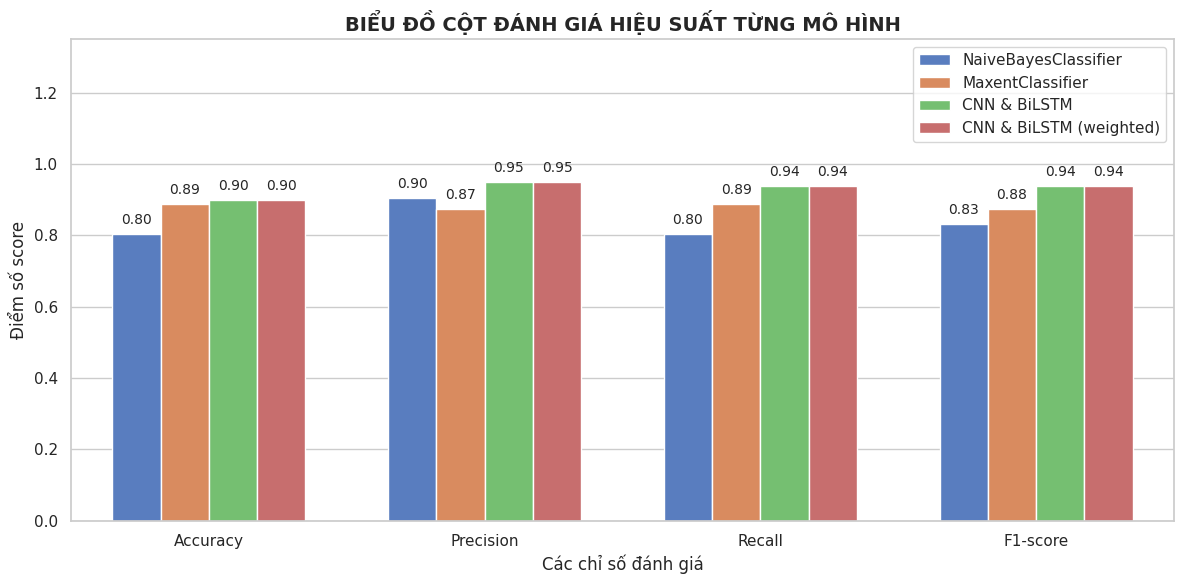

time: 854 ms (started: 2023-12-21 07:16:41 +00:00)


In [147]:
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
plt.ylim(0, (max(data['Score'])+0.4))
sns.barplot(x='Metric', y='Score', hue='Model', data=data, width=0.7, palette='muted', dodge=True)
for i in plt.gca().patches:
    plt.gca().annotate(f'{i.get_height():.2f}', (i.get_x() + i.get_width()/2., i.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)
plt.title('BIỂU ĐỒ CỘT ĐÁNH GIÁ HIỆU SUẤT TỪNG MÔ HÌNH', fontsize=14, fontweight='bold')
plt.xlabel('Các chỉ số đánh giá')
plt.ylabel('Điểm số score')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [150]:
# thời gian chạy
labels_execution = ['NaiveBayesClassifier', 'MaxentClassifier', 'CNN & BiLSTM', 'CNN & BiLSTM (weighted)']
execution_times = [0.068, 54.9, 268, 262]
data_execution = {'Model': labels_execution, 'Time (s)': execution_times}
df_execution = pd.DataFrame(data_execution)

time: 13.4 ms (started: 2023-12-21 07:17:40 +00:00)


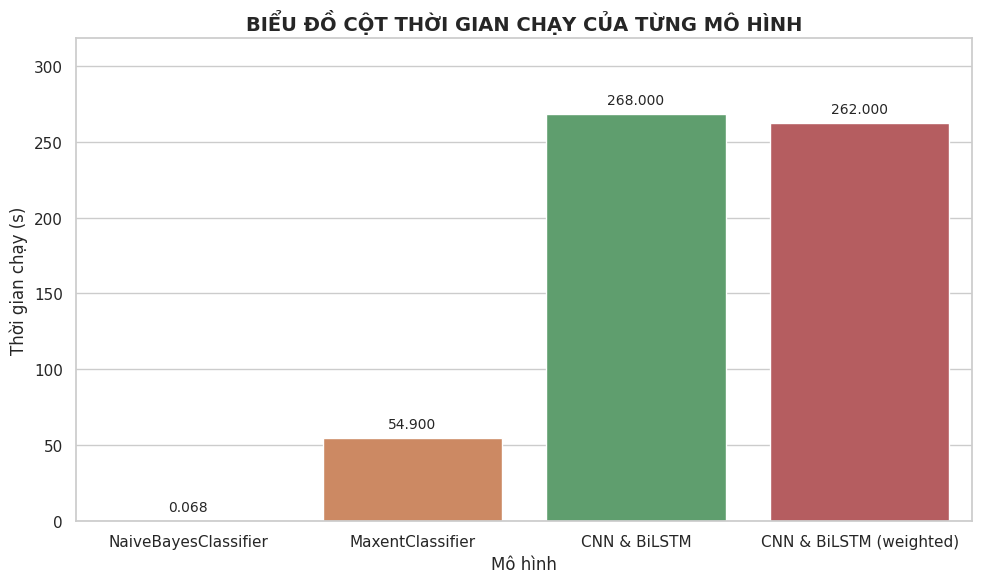

time: 742 ms (started: 2023-12-21 07:17:41 +00:00)


In [151]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
plt.ylim(0, (max(df_execution['Time (s)'])+50))
sns.barplot(x='Model', y='Time (s)', data=df_execution)
for i in plt.gca().patches:
    plt.gca().annotate(f'{i.get_height():.3f}', (i.get_x() + i.get_width()/2., i.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)
plt.title('BIỂU ĐỒ CỘT THỜI GIAN CHẠY CỦA TỪNG MÔ HÌNH', fontsize=14, fontweight='bold')
plt.xlabel('Mô hình')
plt.ylabel('Thời gian chạy (s)')
plt.tight_layout()
plt.show()